<a href="https://colab.research.google.com/github/qt09nt/medical_records_hospital_readmission/blob/main/mimic_bow_full_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Long, A. (2018). Introduction to Clinical Natural Language Processing:
Predicting Hospital Readmission with Discharge Summaries. Retrieved from https://towardsdatascience.com/introduction-to-clinical-natural-language-processing-predicting-hospital-readmission-with-1736d52bc709

Long, A. (2018). MIMIC_bow_full.ipynb. Version 1. Source code. Accessed from https://github.com/andrewwlong/mimic_bow/blob/master/mimic_bow_full.ipynb. 

Doctors have always written clinical notes about their patients - originally, the notes were on paper and were locked away in a cabinet. Fortunately for data scientists, doctors now enter their notes in an electronic medical record. These notes represent a vast wealth of knowledge and insight that can be utilized for predictive models using Natural Language Processing (NLP) to improve patient care and hospital workflow.

This notebook is intended for people interested in healthcare data science and predictive modeling and will help you learn
- How to prepare data for a machine learning project
- How to preprocess the unstructured notes
- How to build a simple predictive model using a bag-of-words approach
- How to assess the quality of your model
- How to decide the next step for improving the model

I recently read this great paper "Scalable and accurate deep learning for electronic health records" by Rajkomar et al. (paper at https://arxiv.org/abs/1801.07860). The authors built many state-of-the-art deep learning models with hospital data to predict in-hospital mortality (AUC = 0.93–0.94), 30-day unplanned readmission (AUC = 0.75–76), prolonged length of stay (AUC = 0.85–0.86) and discharge diagnoses (AUC = 0.90). AUC is a data science performance metric (more about this below) where closer to 1 is better. It is clear that predicting readmission is the hardest task since it has a lower AUC. I was curious how good of a model we can get if use the discharge free-text summaries with a simple predictive model.

# Model definition

Predict which patients are at risk for 30-day unplanned readmission utilizing free-text hospital discharge summaries.

# Data set

We will utilize the MIMIC-III (Medical Information Mart for Intensive Care III), an amazing free hospital database. This database contains de-identified data from over 40,000 patients who were admitted to Beth Israel Deaconess Medical Center in Boston, Massachusetts from 2001 to 2012. In order to get access to the data for this project, you will need to request access at this link (https://mimic.physionet.org/gettingstarted/access/).

In this project, we will make use of the following MIMIC tables
- ADMISSIONS - a table containing admission and discharge dates (has a unique identifier HADM_ID for each admission)
- NOTEEVENTS - contains all notes for each hospitalization (links with HADM_ID)

This notebook assumes that ADMISSIONS.csv and NOTEEVENTS.csv were downloaded and placed in the same folder as this notebook. 

Due to the restricted access, the github version of this code will not show any individual patient data. 

# Step 1. Prepare data

<img src="step_1.jpg">

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
! ls

In [ ]:
!ls -l

In [ ]:
mkdir "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

In [ ]:
! ls "/content/gdrive/My Drive/Colab Notebooks/"

In [ ]:
cd "/content/gdrive/My Drive/Colab Notebooks/"

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
pwd()

'/content/gdrive/My Drive/Colab Notebooks'

In [ ]:
!ls -l

## Load admissions table

In [ ]:
! cp ADMISSIONS.csv "/content/gdrive/My Drive/Colab Notebooks/data"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_adm = pd.read_csv('ADMISSIONS.csv')

In [ ]:
df_adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [ ]:
#list column names and datatypes:
df_adm.dtypes

In [ ]:
# dataframe.size (total number of elements)
size = df_adm.size

# dataframe.shape
shape = df_adm.shape

# dataframe.ndim
df_ndim = df_adm.ndim

print ("Admissions dataframe size:",size, " shape:",  shape,  "  dimensions:",df_ndim)

For this colab notebook we will try to run the full Admissions.csv dataset

In [ ]:
#keep only smaller dataset of 1000 rows to begin
#df_adm = df_adm[:1000]


In [ ]:
#select a random sample of 5 rows of some admissions data frame columns
df_adm[['SUBJECT_ID', 'DISCHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG']] \
    .sample(5, random_state=42)

,SUBJECT_ID,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
40028,29929,2137-04-08 14:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,0
38143,31625,2119-08-23 18:30:00,EMERGENCY,EMERGENCY ROOM ADMIT,ACUTE CORONARY SYNDROME,0
14276,14705,2114-02-03 17:35:00,EMERGENCY,EMERGENCY ROOM ADMIT,PNEUMONIA,0
49801,68457,2129-08-04 16:21:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0
21549,18614,2155-01-13 14:50:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,RESPIRATORY FAILURE,0


In [ ]:
#confirm only 1000 rows kept
print(df_adm.shape)

In [ ]:
df_adm.columns

##### Summary for Admissions Categorical Features

In [ ]:
#describe categorical columns of type np.object
#df_adm[['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE','LANGUAGE', 'RELIGION', 'MARITAL_STATUS','ETHNICITY','EDREGTIME', 'EDOUTTIME','DIAGNOSIS','NEXT_ADMISSION_TYPE']]\
df_adm[['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE','LANGUAGE', 'RELIGION', 'MARITAL_STATUS','ETHNICITY','EDREGTIME', 'EDOUTTIME','DIAGNOSIS']]\
    .describe(include=np.object) \
    .transpose()

,count,unique,top,freq
ADMISSION_TYPE,58976,4,EMERGENCY,42071
ADMISSION_LOCATION,58976,9,EMERGENCY ROOM ADMIT,22754
DISCHARGE_LOCATION,58976,17,HOME,18962
INSURANCE,58976,5,Medicare,28215
LANGUAGE,33644,75,ENGL,29086
RELIGION,58518,20,CATHOLIC,20606
MARITAL_STATUS,48848,7,MARRIED,24239
ETHNICITY,58976,41,WHITE,40996
EDREGTIME,30877,30874,2132-10-26 20:31:00,2
EDOUTTIME,30877,30864,2109-12-10 22:38:00,2


Not all categorical columns have 1000 values, meaning some of them are missing values. 

##### Summary for Numerical Features


In [ ]:
#describe numerical columns
df_adm.describe().transpose()

In [ ]:
df_adm.groupby(['ADMISSION_TYPE']).size()

In [ ]:
#group by Admission type, count distinct admission location, next admission type
adm_type_df = df_adm.groupby('ADMISSION_TYPE') \
              .agg({'ADMISSION_LOCATION':pd.Series.nunique,
                   'NEXT_ADMISSION_TYPE':pd.Series.count}) \
              .rename(columns={'ADMISSION_LOCATION':'number_of_admission_locations',
                              'NEXT_ADMISSION_TYPE':'number_of_next_admissions'}) \
              .sort_values('number_of_admission_locations', ascending=False)

#show top 5 records
adm_type_df.head(5)

##### Visualizing Frequency Distributions

In [ ]:
adm_type_df.describe()

NameError: ignored

In [ ]:
#horizontal boxplot of a dataframe column
adm_type_df[['number_of_next_admissions']].plot(kind='box', vert=False, figsize=(6,2));

In [ ]:
#bar chart of admissions type dataframe column
adm_type_df[['number_of_admission_locations']].plot(kind='bar', figsize=(7,4));

## Convert strings to dates

Many of the hospital admissions are emergency type. Elective admissions are the least frequent type of hospital admissions. 

A note about dates from MIMIC website:
    
    All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future.

When converting dates, it is safer to use a format. For references on formats see http://strftime.org/. Errors = 'coerce' allows NaT (not a datetime) to happen when the string doesn't match the format

In [ ]:
# convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# check to see if there are any missing dates
print('Number of missing date admissions:', df_adm.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', df_adm.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


## Get the next admission date if it exists

In this project, we need the next admission date if it exists. We can get this with the shift() function, but we need to verify the dates are in order. 

In [ ]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE
168,124,2165-12-31 18:55:00,EMERGENCY


In [ ]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-05-21 21:02:00,ELECTIVE
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


But, we want to predict UNPLANNED re-admissions, so we should filter out the ELECTIVE next admissions

In [ ]:
# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,NaT,NaN
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


Now we need to backfill in the values that we removed.


In [ ]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill in case something changed the order above
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill (this will take a little while)
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-12-31 18:55:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


## Calculate days until next admission

In [ ]:
# calculate the number of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

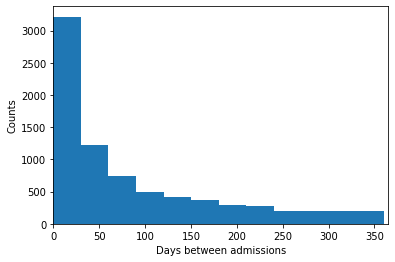

In [ ]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [ ]:
print('Number with a readmission:', (~df_adm.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(df_adm))

## Load the notes

In [ ]:
df_notes = pd.read_csv("NOTEEVENTS.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print('Number of notes:',len(df_notes))

Number of notes: 2083180


There can be multiple notes per hospitalizations so don't worry that the number of notes is higher than the number of hospitalizations. 

In [ ]:
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [ ]:
df_notes.head()

In [ ]:
# look at the first note
df_notes.TEXT.iloc[0]

NameError: ignored

We can see that the dates and PHI have been converted for confidentiality. There are '\n' characters, numbers and punctuation. 

At this point, we have to make a choice on what notes to use. For simplicity, let's use the discharge summary, but we could use all the notes by concatenating them. 

In [ ]:
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [ ]:
assert df_notes_dis_sum.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

AssertionError: ignored

In [ ]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

## Merge data sets

In [ ]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased'

In [ ]:
df_adm_notes.head()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes dataframe by pickling it into df_adm_notes.pickle
pickle_out = open(path + "df_adm_notes.pickle", "wb")
pickle.dump(df_adm_notes, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#open df_adm_notes.pickle
pickle_in = open(path + "df_adm_notes.pickle", "rb")
df_adm_notes = pickle.load(pickle_in)

In [ ]:
import pandas as pd
pd.__version__

'0.25.1'

In [ ]:
len(df_adm_notes)

In [ ]:
df_adm_notes

AttributeError: ignored

Check to see if there are alot of notes that are missing text (might be a sign of a problem).

In [ ]:
print('Fraction of missing notes:', df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes))
print('Fraction notes with newlines:', df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes))
print('Fraction notes with carriage returns:', df_adm_notes.TEXT.str.contains('\r').sum() / len(df_adm_notes))

Fraction of missing notes: 0.1059753119913185
Fraction notes with newlines: 0.8940246880086815
Fraction notes with carriage returns: 0.0


In [ ]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

Remove NEWBORN

In [ ]:
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [ ]:
print('Fraction of missing notes:', df_adm_notes_clean.TEXT.isnull().sum() / len(df_adm_notes_clean))
print('Fraction notes with newlines:', df_adm_notes_clean.TEXT.str.contains('\n').sum() / len(df_adm_notes_clean))
print('Fraction notes with carriage returns:', df_adm_notes_clean.TEXT.str.contains('\r').sum() / len(df_adm_notes_clean))

Fraction of missing notes: 0.03971592354195606
Fraction notes with newlines: 0.9602840764580439
Fraction notes with carriage returns: 0.0


In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes dataframe by pickling it into df_adm_notes.pickle
pickle_out = open(path + "df_adm_notes_clean.pickle", "wb")
pickle.dump(df_adm_notes_clean, pickle_out)
pickle_out.close()

In [ ]:
pip install pandas

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

pickle_in = open(path + "df_adm_notes_clean.pickle", "rb")
df_adm_notes_clean = pickle.load(pickle_in)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:459: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_

In [ ]:
df_adm_notes_clean.head(5)

RecursionError: ignored

Additional analysis might be required to see if there are any specific cases why a discharge would not appear. For now, we will push forward. 

## Prepare a label

I like to create a specific column in the dataframe as OUTPUT_LABEL that has exactly what we are trying to predict. Here we want if the patient was re-admitted within 30 days

In [ ]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [ ]:
print('Number of positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

Number of positive samples: 3004
Number of negative samples: 48109
Total samples: 51113


# Create training and test dataframes

When we build a predictive model, we want the model to work well on data that the model has never seen. To test for this, we take our data and split it into three datasets: training, validation and test. 

- training set: used to train the model
- validation set: data the model didn't see, but are used to optimize or tune the model
- test set: data the model and tuning process never saw (true test of generalizability)

The validation and test set should be as close to the production data as possible. We don't want to make decisions on validation data that is not from same type of data as the test set. For example, don't use high resolution images for validation set if you think production will be amateur photos from your phone. 


In [ ]:
# shuffle the samples
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 7667): 0.061953828094430674
Valid prevalence(n = 7667): 0.056997521846876224
Train all prevalence(n = 35779): 0.05847005226529529
all samples (n = 51113)


In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes_clean dataframe by pickling it into df_adm_notes_clean.pickle
pickle_out = open(path + "df_adm_notes_clean.pickle", "wb")
pickle.dump(df_adm_notes_clean, pickle_out)
pickle_out.close()

Since the prevalence is so low, we want to prevent the model from always predicting negative. To do this, we have a few options
- balance the data by sub-sampling the negatives
- balance the data by over-sampling the positives
- create synthetic data (e.g. SMOTE)

In this example, we will sub-sample the negatives

In [ ]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4184): 0.5


# Step 2: Preprocess text data

Now that we have created data sets that have a label and the notes, we need to preprocess our text data to convert it to something useful (i.e. numbers) for the machine learning model. We are going to use the Bag-of-Words (BOW) approach.

BOW basically breaks up the note into the individual words and counts how many times each word occurs. Your numerical data then becomes counts for some set of words as shown below. BOW is the simplest way to do NLP classification. In most blog posts I have read, fancier techniques have a hard time beating BOW for NLP classification tasks.

In this process, there are few choices that need to be made
- how to pre-process the words
- how to count the words
- which words to use

There is no optimal choice for all NLP projects, so I recommend trying out a few options when building your own models.

You can do the pre-processing in two ways:
- modify the original dataframe TEXT column
- pre-process as part of your pipeline so you don't edit the original data (allows you try out a few options easily)

### Preprocess all the notes

Modify the original dataframe by dealing with the missing text, newlines and carriage returns

In [ ]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    df.TEXT = df.TEXT.str.lower()     #convert the tokens to lowercase
    return df

In [ ]:
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

### Build a tokenizer

Now we need to create a function that splits the note into individual words. This function is called a tokenizer. We can use the nltk.word_tokenize function to this for us. 

In [ ]:
import sys
!python -m pip install nltk

In [ ]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')
word_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['This',
 'should',
 'be',
 'tokenized',
 '.',
 '02/02/2018',
 'sentence',
 'has',
 'stars**']

#### Try using Spacy for word pre-processing, with part of speech tagging:

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
for i, row in df_train.iterrows():
    if(row['TEXT'] and len(str(row["TEXT"])) < 1000000):
        doc = nlp(str(row["TEXT"]))
        adjectives = []
        nouns =[]
        verbs = []
        lemmas = []
                 
        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ =="ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ =="VERB":
                verbs.append(token.lemma_)
                  
        df_train.at[i, "selftext_lemma"] = " ".join(lemmas)
        df_train.at[i, "selftext_nouns"] = " ".join(nouns)
        df_train.at[i, "selftext_adjectives"] = " ".join(adjectives)
        df_train.at[i, "selftext_verbs"] = " ".join(verbs)
        df_train.at[i, "selftext_nav"] = " ".join(nouns+adjectives+verbs)
        df_train.at[i, "no_tokens"] = len(lemmas)

In [ ]:
df_train.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT,OUTPUT_LABEL,selftext_lemma,selftext_nouns,selftext_adjectives,selftext_verbs,selftext_nav,no_tokens
0,3333,134061,2144-05-06 08:00:00,2144-05-12 14:05:00,17.953472,2144-05-30 12:58:00,ELECTIVE,NaT,admission date: [**2144-5-6**] d...,1,admission date : [ * * 2144 - 5 - 6 * * ] ...,admission date discharge date date birth sex s...,chief right major surgical invasive median med...,gortex know prove present receive give resect ...,admission date discharge date date birth sex s...,1056.0
1,17425,171757,2149-01-10 17:48:00,2149-01-14 11:15:00,12.033333,2149-01-26 12:03:00,EMERGENCY,NaT,admission date: [**2149-1-10**] ...,1,admission date : [ * * 2149 - 1 - 10 * * ] ...,admission date discharge date service allergy ...,neurosurgery chief subdural major surgical inv...,record have know trip fall take land t'ferre s...,admission date discharge date service allergy ...,1353.0
2,47216,116008,2145-02-20 20:00:00,2145-02-23 15:09:00,3810.845139,2155-08-01 11:26:00,URGENT,NaT,admission date: [**2145-2-20**] discharge...,0,admission date : [ * * 2145 - 2 - 20 * * ] ...,admission date discharge date date birth sex s...,chief present old prior cardiac exertional las...,know present note see note undergo report repo...,admission date discharge date date birth sex s...,1285.0
3,52529,187654,2184-03-09 14:07:00,2184-04-02 11:40:00,2.069444,2184-04-04 13:20:00,EMERGENCY,NaT,admission date: [**2184-3-9**] d...,1,admission date : [ * * 2184 - 3 - 9 * * ] ...,admission date discharge date date birth sex s...,adverse chief major surgical invasive orif tra...,know closure swerve prolong note bring give re...,admission date discharge date date birth sex s...,2994.0
4,11740,137487,2154-02-26 11:32:00,2154-02-27 08:00:00,0.029861,2154-02-27 08:43:00,EMERGENCY,2154-02-27 08:00:00,admission date: [**2154-2-26**] ...,1,admission date : [ * * 2154 - 2 - 26 * * ] ...,admission date discharge date date birth sex s...,chief unresponsive major surgical invasive ang...,record have know have present intubate sedate ...,admission date discharge date date birth sex s...,3043.0


In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes dataframe by pickling it into df_adm_notes.pickle
pickle_out = open(path + "df_train.pickle", "wb")
pickle.dump(df_train, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load df_train into our current script
pickle_in = open(path + "df_train.pickle", "rb")
df_train = pickle.load(pickle_in)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
for i, row in df_valid.iterrows():
    if(row['TEXT'] and len(str(row["TEXT"])) < 1000000):
        doc = nlp(str(row["TEXT"]))
        adjectives = []
        nouns =[]
        verbs = []
        lemmas = []
                 
        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ =="ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ =="VERB":
                verbs.append(token.lemma_)
                  
        df_valid.at[i, "selftext_lemma"] = " ".join(lemmas)
        df_valid.at[i, "selftext_nouns"] = " ".join(nouns)
        df_valid.at[i, "selftext_adjectives"] = " ".join(adjectives)
        df_valid.at[i, "selftext_verbs"] = " ".join(verbs)
        df_valid.at[i, "selftext_nav"] = " ".join(nouns+adjectives+verbs)
        df_valid.at[i, "no_tokens"] = len(lemmas)

In [ ]:
df_valid.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT,OUTPUT_LABEL,selftext_lemma,selftext_nouns,selftext_adjectives,selftext_verbs,selftext_nav,no_tokens
9061,88526,108529,2188-07-25 01:46:00,2188-07-31 14:45:00,NaN,NaT,EMERGENCY,NaT,"name: [**known lastname **],[**known firstnam...",0,"name : [ * * know lastname * * ] , [ * * kno...",name lastname firstname unit numeric identifie...,clinical extensive full prolonged reasonable r...,know know record have know update base would m...,name lastname firstname unit numeric identifie...,275.0
4144,3708,133058,2181-11-21 11:15:00,2181-11-26 14:00:00,NaN,NaT,ELECTIVE,NaT,admission date: [**2181-11-21**] discha...,0,admission date : [ * * 2181 - 11 - 21 * * ] ...,admission date discharge date date birth sex s...,present old non physical general young acute e...,know reactive nondistende orient undergo monit...,admission date discharge date date birth sex s...,572.0
26434,16644,183141,2183-11-24 07:15:00,2183-12-01 13:20:00,NaN,NaT,ELECTIVE,NaT,admission date: [**2183-11-24**] ...,0,admission date : [ * * 2183 - 11 - 24 * * ] ...,admission date discharge date service cardioth...,chief major surgical invasive present female n...,know know carotid peak reveal dyspnea walk sle...,admission date discharge date service cardioth...,1633.0
3222,3320,185608,2170-01-13 23:07:00,2170-01-14 12:00:00,NaN,NaT,EMERGENCY,2170-01-14 12:00:00,admission date: [**2170-1-13**] ...,0,admission date : [ * * 2170 - 1 - 13 * * ] ...,admission date discharge date date birth sex s...,chief mental major surgical invasive present a...,penicillin contain transfer present alter brin...,admission date discharge date date birth sex s...,1194.0
2982,4074,137421,2204-02-04 07:26:00,2204-02-06 01:40:00,NaN,NaT,EMERGENCY,2204-02-06 01:40:00,admission date: [**2204-2-4**] d...,0,admission date : [ * * 2204 - 2 - 4 * * ] ...,admission date discharge date service medicine...,chief major surgical invasive present atrial n...,record have know bring find give deny have acc...,admission date discharge date service medicine...,1090.0


In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes dataframe by pickling it into df_adm_notes.pickle
pickle_out = open(path + "df_valid.pickle", "wb")
pickle.dump(df_valid, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load df_valid into our current script
pickle_in = open(path + "df_valid.pickle", "rb")
df_valid = pickle.load(pickle_in)

In [ ]:
for i, row in df_test.iterrows():
    if(row['TEXT'] and len(str(row["TEXT"])) < 1000000):
        doc = nlp(str(row["TEXT"]))
        adjectives = []
        nouns =[]
        verbs = []
        lemmas = []
                 
        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ =="ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ =="VERB":
                verbs.append(token.lemma_)
                  
        df_test.at[i, "selftext_lemma"] = " ".join(lemmas)
        df_test.at[i, "selftext_nouns"] = " ".join(nouns)
        df_test.at[i, "selftext_adjectives"] = " ".join(adjectives)
        df_test.at[i, "selftext_verbs"] = " ".join(verbs)
        df_test.at[i, "selftext_nav"] = " ".join(nouns+adjectives+verbs)
        df_test.at[i, "no_tokens"] = len(lemmas)

In [ ]:
df_test.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT,OUTPUT_LABEL,selftext_lemma,selftext_nouns,selftext_adjectives,selftext_verbs,selftext_nav,no_tokens
25234,60515,185276,2114-11-03 14:39:00,2114-11-07 16:15:00,NaN,NaT,EMERGENCY,NaT,admission date: [**2114-11-3**] ...,0,admission date : [ * * 2114 - 11 - 3 * * ] ...,admission date discharge date date birth sex s...,chief major surgical invasive present old open...,record have know readmitte present keep attemp...,admission date discharge date date birth sex s...,2311.0
11550,28829,198739,2120-07-29 13:49:00,2120-08-15 10:40:00,NaN,NaT,EMERGENCY,2120-08-15 10:40:00,admission date: [**2120-7-29**] ...,0,admission date : [ * * 2120 - 7 - 29 * * ] ...,admission date discharge date date birth sex s...,iodine chief abdominal major surgical invasive...,expire treat tranferre state decrease come beg...,admission date discharge date date birth sex s...,2199.0
26803,43215,185227,2117-01-09 20:04:00,2117-01-19 13:40:00,NaN,NaT,EMERGENCY,2117-01-19 13:40:00,admission date: [**2117-1-9**] d...,0,admission date : [ * * 2117 - 1 - 9 * * ] ...,admission date discharge date service medicine...,adverse chief major surgical invasive present ...,know fall present happen give shovel sustain s...,admission date discharge date service medicine...,3012.0
25588,97178,101679,2105-05-22 22:26:00,2105-05-25 17:26:00,NaN,NaT,EMERGENCY,NaT,admission date: [**2105-5-22**] ...,0,admission date : [ * * 2105 - 5 - 22 * * ] ...,admission date discharge date date birth sex s...,adverse chief major surgical invasive cardiac ...,know note have note would go stop take develop...,admission date discharge date date birth sex s...,3582.0
46135,42843,143051,2170-10-30 11:15:00,2170-11-17 10:40:00,NaN,NaT,ELECTIVE,NaT,admission date: [**2170-10-30**] ...,0,admission date : [ * * 2170 - 10 - 30 * * ] ...,admission date discharge date date birth sex s...,chief major surgical invasive last myotomy pre...,dilate die die know admit follow tolerate extu...,admission date discharge date date birth sex s...,1228.0


In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes dataframe by pickling it into df_adm_notes.pickle
pickle_out = open(path + "df_test.pickle", "wb")
pickle.dump(df_test, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load df_test into our current script
pickle_in = open(path + "df_test.pickle", "rb")
df_test = pickle.load(pickle_in)

Note that some punctuation is separated but not all punctuation. 

We can define our own custom tokenizer. Our tokenizer will 
- replace punctuation with spaces
- remove numbers with spaces
- lowercase all words

I like to do these steps as part of the tokenizer, so I can go back and look at the original note. The new line and carriage return is more difficult to deal with so I did it in the preprocessing step above. 

In [ ]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)   #convert to lowercase
    tokens = word_tokenize(text)
    return tokens

In [ ]:
tokenizer_better('This should be tokenized. 02/02/2018 sentence has stars**')

['this', 'should', 'be', 'tokenized', 'sentence', 'has', 'stars']

#### Creating a List of Tokens from a list of Documents

In [ ]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [ ]:
#transform list of documents into a single list of tokens
tokens = df_train.selftext_nouns.map(my_tokenizer).sum()

In [ ]:
print (tokens[:200])

['admission', 'date', 'discharge', 'date', 'date', 'birth', 'sex', 'service', 'cardiothoracic', 'allergy', 'zyban', 'name3', 'lf', 'complaint', 'stage', 'iiib', 't4', 'carcinoma', 'lung', 'procedure', 's', 'p', 'sternotomy', 'mass', 'w/', 'svc', 'history', 'illness', 'mr', '.', 'lastname', 'gentleman', 'biopsy', 't4', 'carcinoma', 'upper', 'lobe', 'vena', 'caval', 'syndrome', 'induction', 'chemoradiotherapy', 'response', 'evidence', 'disease', 'reserve', 'youth', 'performance', 'status', 'approach', 'disease', 'vein', 'admission', 'history', '-stage', 'iiib', 't4', 'nsclca', 'p', 'rul', 'lobectomy', 'bloc', 'w/', 'svc', 'brachiocephalic', 'resection', 'doctor', 'name', 'reconstruction', 'svc', 'brachiocephalic', 'p', 'radiation', 'chemotherapy', 'history', 'history', 'tobacco', 'use', 'partner', 'location', 'un', 'company', 'research', 'equipment', 'family', 'history', 'cad', 'relative', 'father', 'mi', 'age', 'exam', 'man', 'nad', 'heent', 'swelling', 'w/', 'svc', 'syndrome', 'chest',

In [ ]:
type(tokens)

list

**Topic Modelling with LDA**

In [ ]:
#keeping just nouns, adjectives, verbs from train dataset:
tokens_train_nav = df_train.selftext_nav.map(my_tokenizer).sum()

In [ ]:
tokens_train_nav

['admission',
 'date',
 'discharge',
 'date',
 'date',
 'birth',
 'sex',
 'service',
 'cardiothoracic',
 'allergy',
 'zyban',
 'name3',
 'lf',
 'complaint',
 'stage',
 'iiib',
 't4',
 'carcinoma',
 'lung',
 'procedure',
 's',
 'p',
 'sternotomy',
 'mass',
 'w/',
 'svc',
 'history',
 'illness',
 'mr',
 '.',
 'lastname',
 'gentleman',
 'biopsy',
 't4',
 'carcinoma',
 'upper',
 'lobe',
 'vena',
 'caval',
 'syndrome',
 'induction',
 'chemoradiotherapy',
 'response',
 'evidence',
 'disease',
 'reserve',
 'youth',
 'performance',
 'status',
 'approach',
 'disease',
 'vein',
 'admission',
 'history',
 '-stage',
 'iiib',
 't4',
 'nsclca',
 'p',
 'rul',
 'lobectomy',
 'bloc',
 'w/',
 'svc',
 'brachiocephalic',
 'resection',
 'doctor',
 'name',
 'reconstruction',
 'svc',
 'brachiocephalic',
 'p',
 'radiation',
 'chemotherapy',
 'history',
 'history',
 'tobacco',
 'use',
 'partner',
 'location',
 'un',
 'company',
 'research',
 'equipment',
 'family',
 'history',
 'cad',
 'relative',
 'father',
 

In [ ]:
import pickle

path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out tokens_train_nav by pickling it into tokens_train_nav.pickle
pickle_out = open(path + 'tokens_train_nav.pkl', 'wb')
pickle.dump(tokens_train_nav, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load df_test into our current script
pickle_in = open(path + "tokens_train_nav.pkl", "rb")
tokens_train_nav = pickle.load(pickle_in)

In [ ]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#define a function to prepare text for topic modelling (remove stop words):
def prepare_text_for_lda(text):
  tokens_lda = [token for token in tokens if token not in en_stop]
  return tokens_lda

In [ ]:
lda_tokens = [prepare_text_for_lda(tokens_train_nav)]

In [ ]:
lda_tokens

[['admission',
  'date',
  'discharge',
  'date',
  'date',
  'birth',
  'sex',
  'service',
  'cardiothoracic',
  'allergy',
  'zyban',
  'name3',
  'lf',
  'complaint',
  'stage',
  'iiib',
  't4',
  'carcinoma',
  'lung',
  'procedure',
  'p',
  'sternotomy',
  'mass',
  'w/',
  'svc',
  'history',
  'illness',
  'mr',
  '.',
  'lastname',
  'gentleman',
  'biopsy',
  't4',
  'carcinoma',
  'upper',
  'lobe',
  'vena',
  'caval',
  'syndrome',
  'induction',
  'chemoradiotherapy',
  'response',
  'evidence',
  'disease',
  'reserve',
  'youth',
  'performance',
  'status',
  'approach',
  'disease',
  'vein',
  'admission',
  'history',
  '-stage',
  'iiib',
  't4',
  'nsclca',
  'p',
  'rul',
  'lobectomy',
  'bloc',
  'w/',
  'svc',
  'brachiocephalic',
  'resection',
  'doctor',
  'name',
  'reconstruction',
  'svc',
  'brachiocephalic',
  'p',
  'radiation',
  'chemotherapy',
  'history',
  'history',
  'tobacco',
  'use',
  'partner',
  'location',
  'un',
  'company',
  'resea

In [ ]:
type(lda_tokens)

list

In [ ]:
#check the frequency counter for the tokens from the train nouns, adjectives and verbs (nav) column
from collections import Counter 
counter = Counter(tokens_train_nav)
counter.most_common(20)

[('mg', 62090),
 ('tablet', 49652),
 ('patient', 41262),
 ('po', 39998),
 ('day', 37827),
 ('blood', 34534),
 ('discharge', 33671),
 ('name', 33379),
 ('sig', 33064),
 ('daily', 29034),
 ('.', 24289),
 ('last', 23014),
 ('history', 22881),
 ('_', 20225),
 ('time', 18722),
 ('admission', 17272),
 ('pain', 17257),
 ('right', 16833),
 ('date', 16346),
 ('hospital', 15558)]

In [ ]:
import pickle

path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out lda_tokens by pickling it into lda_tokens.pickle
pickle_out = open(path + 'lda_tokens.pkl', "wb")
pickle.dump(lda_tokens, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load lda_tokens.pkl into our current script
pickle_in = open(path + "lda_tokens.pkl", "rb")
lda_tokens = pickle.load(pickle_in)

In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(lda_tokens)
corpus = [dictionary.doc2bow(text) for text in lda_tokens]

import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"
pickle_out = open(path + 'corpus.pkl', "wb")
pickle.dump(corpus, pickle_out)
dictionary.save('dictionary.gensim')
pickle_out.close()

In [ ]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes = 15)
ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
  print(topic)

(0, '0.021*"mg" + 0.017*"tablet" + 0.017*"po" + 0.014*"name"')
(1, '0.006*"mg" + 0.004*"blood" + 0.004*"patient" + 0.004*"tablet"')
(2, '0.021*"mg" + 0.016*"patient" + 0.016*"tablet" + 0.011*"po"')
(3, '0.023*"mg" + 0.016*"tablet" + 0.015*"day" + 0.015*"patient"')
(4, '0.011*"mg" + 0.006*"day" + 0.006*"blood" + 0.006*"po"')


In [ ]:
topics

[(0, '0.024*"mg" + 0.018*"tablet" + 0.014*"po" + 0.014*"patient"'),
 (1, '0.008*"mg" + 0.006*"patient" + 0.006*"day" + 0.006*"sig"'),
 (2, '0.020*"mg" + 0.017*"tablet" + 0.014*"discharge" + 0.013*"day"'),
 (3, '0.026*"mg" + 0.015*"patient" + 0.014*"day" + 0.013*"sig"'),
 (4, '0.018*"mg" + 0.016*"tablet" + 0.015*"day" + 0.015*"po"')]

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')

import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load corpus.pkl into our current script
pickle_in = open(path + "corpus.pkl", "rb")
corpus = pickle.load(pickle_in)

lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is

AttributeError: ignored

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load corpus.pkl into our current script
pickle_in = open(path + "corpus.pkl", "rb")
corpus = pickle.load(pickle_in)

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load corpus.pkl into our current script
pickle_in = open(path + "ldamodel.pkl", "rb")
ldamodel = pickle.load(pickle_in)

In [ ]:
import os
!python -m pip install pyLDAvis

In [ ]:
pip list


In [ ]:
import pandas
pandas.__version__

'0.25.1'

**pyLDAvis appears to require pandas version 0.25.1**

to get the pandas version 0.25.1, first install it using
 
 import os
 !python -m pip install pandas==0.25.1

Restart Google Runtime In toolbar go to Runtime->Restart Runtime...

In [ ]:
pip install pandas==0.25.1

In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

ModuleNotFoundError: ignored

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load corpus.pkl into our current script
pickle_in = open(path + "lda_viz.pkl", "rb")
lda_viz = pickle.load(pickle_in)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

#turn on automatic rendering of visualizations
pyLDAvis.enable_notebook()

lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:387: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
pyLDAvis.display(lda_viz)

**Compute Model Perplexity and Coherence Score**

Perplexity is an evaluation measure which captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set. 

-perplexity metric measures how probable some new unseen data is given the model that was learned earlier. How well does the model represent or reproduce the statistics of the held-out data. 

In [ ]:
#Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))   # a measure of how good the model is. the lower the better. 


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)



Perplexity:  -7.4633513233114295


In [ ]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=lda_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

NameError: ignored

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"
pickle_out = open(path + 'lda_viz.pkl', "wb")
pickle.dump(lda_viz, pickle_out)
pickle_out.close()

In [ ]:
pyLDAvis.__version__

'2.1.0'

In [ ]:
import gensim

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


FileNotFoundError: ignored

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')

import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load corpus.pkl into our current script
pickle_in = open(path + "corpus.pkl", "rb")
corpus = pickle.load(pickle_in)


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


FileNotFoundError: ignored

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"
pickle_in = open(path + "ldamodel.pkl", "rb")
lda = pickle.load(pickle_in)


In [ ]:
import os
!python -m pip install pandas==0.25.1

In [ ]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

AttributeError: ignored

It looks like the topics are not very well defined because the most frequent words such as "mg", "tablet", "day", "patient" appear in basically all 5 topics. So let's try removing them.

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"
pickle_out = open(path + 'ldamodel.pkl', "wb")
pickle.dump(ldamodel, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load ldamodel into our current script
pickle_in = open(path + "ldamodel.pkl", "rb")
ldamodel = pickle.load(pickle_in)

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out tokens dataframe by pickling it into tokens.pickle
pickle_out = open(path + "tokens.pickle", "wb")
pickle.dump(tokens, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load tokens into our current script
pickle_in = open(path + "tokens.pickle", "rb")
tokens = pickle.load(pickle_in)

### Counting Frequencies with a Counter

In [ ]:
from collections import Counter 
counter = Counter(tokens)
counter.most_common(20)

[('mg', 62090),
 ('tablet', 47234),
 ('po', 39875),
 ('patient', 38236),
 ('day', 37827),
 ('blood', 34533),
 ('name', 33192),
 ('sig', 33050),
 ('discharge', 29044),
 ('daily', 26765),
 ('.', 24289),
 ('history', 22881),
 ('_', 20225),
 ('time', 18660),
 ('admission', 17244),
 ('pain', 17131),
 ('date', 16201),
 ('hospital', 15551),
 ('medication', 14727),
 ('%', 14580)]

In [ ]:
#additional stop words to remove, which includes the most frequently found words
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also', 'mg', 'tablet', 'po', 'patient', 'day']

In [ ]:
#import NLTK stopword package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#loading stopwords into a lilst
stop_words_list=stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Add the custom stop words list to the NLTK library's predefined stop words list

final_stopword_list = my_stop_words + stop_words_list

In [ ]:
final_stopword_list_set = set(final_stopword_list)

In [ ]:
#define a function to prepare text for topic modelling (remove stop words):
def prepare_text_for_lda_custom_stop(text):
  tokens_lda_custom = [token for token in tokens if token not in final_stopword_list_set]
  return tokens_lda_custom

In [ ]:
lda_tokens_custom = [prepare_text_for_lda_custom_stop(tokens_train_nav)]

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out tokens dataframe by pickling it into tokens.pickle
pickle_out = open(path + "lda_tokens_custom.pickle", "wb")
pickle.dump(lda_tokens_custom, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load lda_tokens_custom.pickle into our current script
pickle_in = open(path + "lda_tokens_custom.pickle", "rb")
lda_tokens_custom = pickle.load(pickle_in)

In [ ]:
from gensim import corpora
dictionary_custom = corpora.Dictionary(lda_tokens_custom)
#corpus_custom = [dictionary.doc2bow(text) for text in lda_tokens_custom]
corpus_custom = [dictionary_custom.doc2bow(text) for text in lda_tokens_custom]


In [ ]:
import pickle

path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out tokens dataframe by pickling it into tokens.pickle
pickle_out = open(path + "corpus_custom.pkl", "wb")
pickle.dump(corpus_custom, pickle_out)
pickle_out.close()

In [ ]:
import pickle

path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out tokens dataframe by pickling it into tokens.pickle
pickle_out = open(path + "dictionary_custom.pkl", "wb")
pickle.dump(dictionary_custom, pickle_out)
pickle_out.close()

we can find 10 topics:


In [ ]:
import gensim
NUM_TOPICS = 10
ldamodel_custom = gensim.models.ldamodel.LdaModel(corpus_custom, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.001*"daily" + 0.001*"blood" + 0.001*"discharge" + 0.001*"history"')
(1, '0.005*"blood" + 0.005*"discharge" + 0.004*"history" + 0.004*"_"')
(2, '0.014*"blood" + 0.013*"sig" + 0.012*"discharge" + 0.011*"daily"')
(3, '0.004*"blood" + 0.004*"sig" + 0.003*"_" + 0.003*"daily"')
(4, '0.003*"blood" + 0.003*"sig" + 0.002*"." + 0.002*"discharge"')
(5, '0.003*"blood" + 0.003*"sig" + 0.002*"admission" + 0.002*"history"')
(6, '0.011*"blood" + 0.010*"sig" + 0.009*"daily" + 0.007*"time"')
(7, '0.002*"blood" + 0.001*"sig" + 0.001*"discharge" + 0.001*"."')
(8, '0.002*"sig" + 0.002*"blood" + 0.002*"history" + 0.001*"discharge"')
(9, '0.002*"sig" + 0.001*"history" + 0.001*"time" + 0.001*"blood"')


In [ ]:
import pickle

path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out tokens dataframe by pickling it into tokens.pickle
pickle_out = open(path + "ldamodel_custom.pickle", "wb")
pickle.dump(ldamodel_custom, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load lda_tokens_custom.pickle into our current script
pickle_in = open(path + "ldamodel_custom.pickle", "rb")
ldamodel_custom = pickle.load(pickle_in)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
from pprint import pprint

#print the keyword in the 10 topics
pprint(ldamodel_custom.print_topics())
doc_lda = ldamodel_custom[corpus_custom]

[(0,
  '0.002*"blood" + 0.001*"sig" + 0.001*"history" + 0.001*"daily" + 0.001*"_" + '
  '0.001*"discharge" + 0.001*"." + 0.001*"time" + 0.001*"hospital" + '
  '0.001*"pain"'),
 (1,
  '0.001*"blood" + 0.001*"sig" + 0.001*"discharge" + 0.001*"." + 0.001*"_" + '
  '0.001*"daily" + 0.001*"history" + 0.001*"admission" + 0.001*"time" + '
  '0.001*"#"'),
 (2,
  '0.003*"blood" + 0.002*"sig" + 0.002*"discharge" + 0.001*"daily" + '
  '0.001*"time" + 0.001*"admission" + 0.001*"history" + 0.001*"." + '
  '0.001*"hospital" + 0.001*"medication"'),
 (3,
  '0.014*"blood" + 0.013*"sig" + 0.012*"discharge" + 0.010*"daily" + 0.010*"." '
  '+ 0.009*"history" + 0.008*"_" + 0.007*"time" + 0.007*"pain" + '
  '0.007*"admission"'),
 (4,
  '0.003*"sig" + 0.003*"discharge" + 0.002*"blood" + 0.002*"history" + '
  '0.002*"daily" + 0.002*"." + 0.002*"_" + 0.001*"time" + 0.001*"admission" + '
  '0.001*"medication"'),
 (5,
  '0.001*"blood" + 0.001*"sig" + 0.001*"daily" + 0.001*"discharge" + 0.001*"." '
  '+ 0.001*"hi

**LDA Interpretation**

'0.002*"blood" + 0.001*"sig" + 0.001*"history" + 0.001*"daily" + 0.001*"_" + '
  '0.001*"discharge" + 0.001*"." + 0.001*"time" + 0.001*"hospital" + '
  '0.001*"pain"'),

This means that topic 0 has the top 10 keywords 'blood', 'sig', 'history' etc.
The weight of the word 'blood' is 0.002.

Weight refers to how important a keyword is to that topic.

**pyLDAvis**  

interpret topics in a topic model fit to a corpus of text data


In [ ]:
import sys
!python -m pip install pyLDAvis==2.1.0

In [ ]:
import sys
!python -m pip install numexpr

In [ ]:
import sys
!python -m pip install pandas

In [ ]:
import sys
!pip install --user pandas


In [ ]:
import gensim

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')

import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load vocab into our current script
pickle_in = open(path + "corpus_custom.pickle", "rb")
corpus_custom = pickle.load(pickle_in)


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning: This function is

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load vocab into our current script
pickle_in = open(path + "ldamodel_custom.pickle", "rb")
lda_custom = pickle.load(pickle_in)


In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

#turn on automatic rendering of visualizations
pyLDAvis.enable_notebook()

lda_custom_viz = gensimvis.prepare(lda_custom, corpus_custom, dictionary)
pyLDAvis.display(lda_custom_viz)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:387: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


**Interpreting pyLDAvis graphics**

saliency = measure of how much the term tells you about the topic

relevance= a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.

Each bubble on the left hand side plot represents a topic. The larger the bubble, the more prevalent is that topic. 

The size of the bubble measures the importance of the topics, relative to the data.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart. 


In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"
pickle_out = open(path + 'ldacustom_viz.pkl', "wb")
pickle.dump(ldamodel, pickle_out)
pickle_out.close()

In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

#turn on automatic rendering of visualizations
pyLDAvis.enable_notebook()

lda_custom_viz = gensimvis.prepare(lda_custom, corpus_custom, dictionary)
pyLDAvis.display(lda_custom_viz)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:387: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
pyLDAvis.enable_notebook()
lda_custom_viz

NameError: ignored

In [ ]:
import pickle

path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out tokens dataframe by pickling it into tokens.pickle
pickle_out = open(path + "lda_custom_viz.pickle", "wb")
pickle.dump(lda_custom_viz, pickle_out)
pickle_out.close()

In [ ]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
lda_display = gensimvis.prepare(lda_custom, corpus_custom, dictionary)
pyLDAvis.display(lda_display)

AttributeError: ignored

In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
#lda_viz = gensimvis.prepare(ldamodel_custom, corpus_custom, dictionary_custom)
lda_viz = pyLDAvis.gensim.prepare(ldamodel_custom, corpus_custom, dictionary_custom)

pyLDAvis.display(lda_viz)


AttributeError: ignored

From the counter, it shows that the word "tablet" is the most frequent word, appearing 1023 times within the notes which correspond to the subset of 1000 rows of the Admissions dataframe. 

To double check what "tablet" means, we can take a look at one of the example admission notes.

In [ ]:
#looking at the TEXT column of the df_train dataframe, first admission note. 
df_train.TEXT.iloc[0]

"admission date:  [**2144-5-6**]              discharge date:   [**2144-5-12**]  date of birth:  [**2096-7-8**]             sex:   m  service: cardiothoracic  allergies: zyban  attending:[**first name3 (lf) 2969**] chief complaint: stage iiib (t4) carcinoma of the right lung.   major surgical or invasive procedure: s/p median sternotomy for mediastinal mass w/ gortex to svc.   history of present illness: mr. [**known lastname 8878**] is a 48-year-old gentleman with biopsy-proven t4 carcinoma of the right upper lobe presenting a superior vena caval syndrome. he received induction chemoradiotherapy with an excellent response and no evidence for distant disease. he had adequate functional reserve, and given his youth and good performance status, an aggressive approach to resect the disease and reconstruct his central veins was planned for this admission.  past medical history: -stage iiib (t4) nsclca -s/p rul lobectomy en bloc w/ svc and brachiocephalic veins resection and [**doctor last 

From the example admission note above, it's clear that the word "tablet" refers to medication tablets ie. "2 mg tablet..", "bisacodyl 5 mg tablet", "prednisone 1 mg tablet", "lorazepam 1 mg tablet" etc. These examples all refer to "tablet" in the sense of drug tablets, meaning dosage of a drug in number of tablet units. 

#### Simplified plotting of the most common tokens: convert the list of tuples into a dataframe.

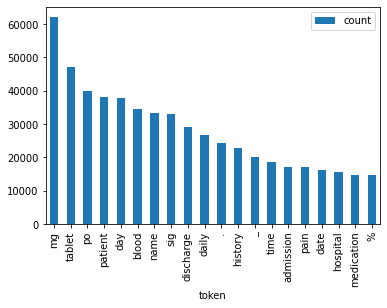

In [ ]:
#convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])
    
#create bar plot
freq_df.plot(kind='bar', x = 'token');

### Using Word Clouds

In [ ]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordcloud wrapper"""
    wc = WordCloud(width = 1200, height=800,
                  background_color= "white",
                  max_words=200)
    wc.generate_from_frequencies(counter)
    
    #Plot 
    fig=plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

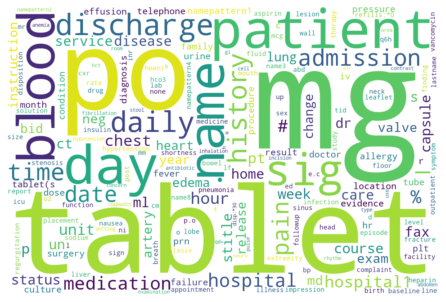

In [ ]:
import matplotlib.pyplot as plt

#create the word cloud by calling the function

wordcloud(counter)

In [ ]:
# render plots as rentina or png
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    ''' Wrapper for sns boxplot with cut-off functionality'''
    #plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    
    #order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
    
    sns.boxplot(x=x, y=y, data=data, palette='Set2',
               order=ordered_values)
    
    fig.set_size_inches(11,6)
    
    #cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

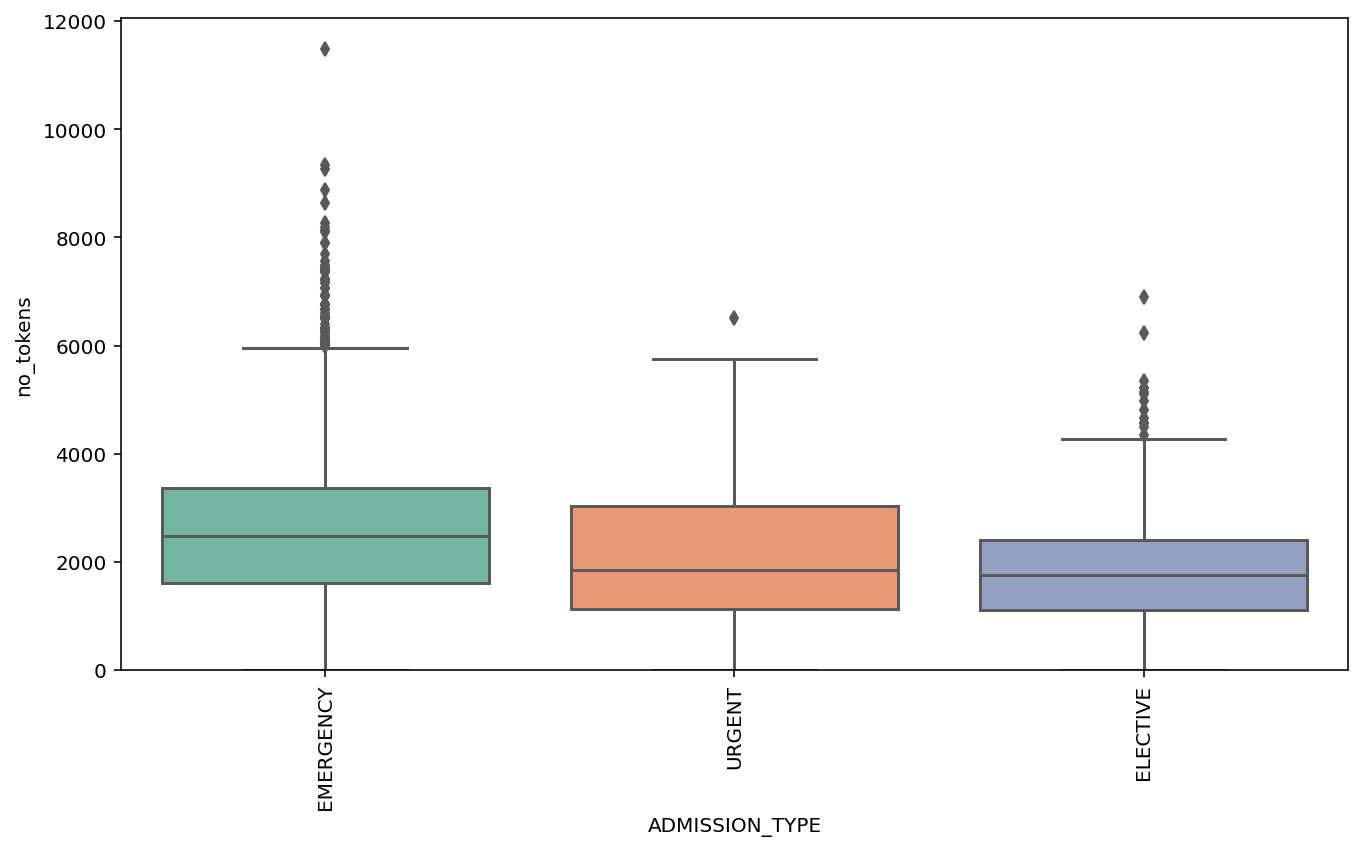

In [ ]:
multi_boxplot(df_train, 'ADMISSION_TYPE', 'no_tokens')

In [ ]:
#print text of outliers
df_train['selftext_lemma'][df_train.no_tokens > 1500]

3       admission date :   [ * * 2184 - 3 - 9 * * ]   ...
4       admission date :   [ * * 2154 - 2 - 26 * * ]  ...
7       admission date :   [ * * 2183 - 8 - 31 * * ]  ...
8       admission date :   [ * * 2132 - 12 - 3 * * ]  ...
9       admission date :   [ * * 2170 - 1 - 18 * * ]  ...
                              ...                        
4177    admission date :   [ * * 2176 - 6 - 20 * * ]  ...
4179    admission date :   [ * * 2121 - 3 - 31 * * ]  ...
4181    admission date :   [ * * 2162 - 5 - 16 * * ]  ...
4182    admission date :   [ * * 2126 - 9 - 15 * * ]  ...
4183    admission date :   [ * * 2189 - 11 - 20 * * ] ...
Name: selftext_lemma, Length: 3123, dtype: object

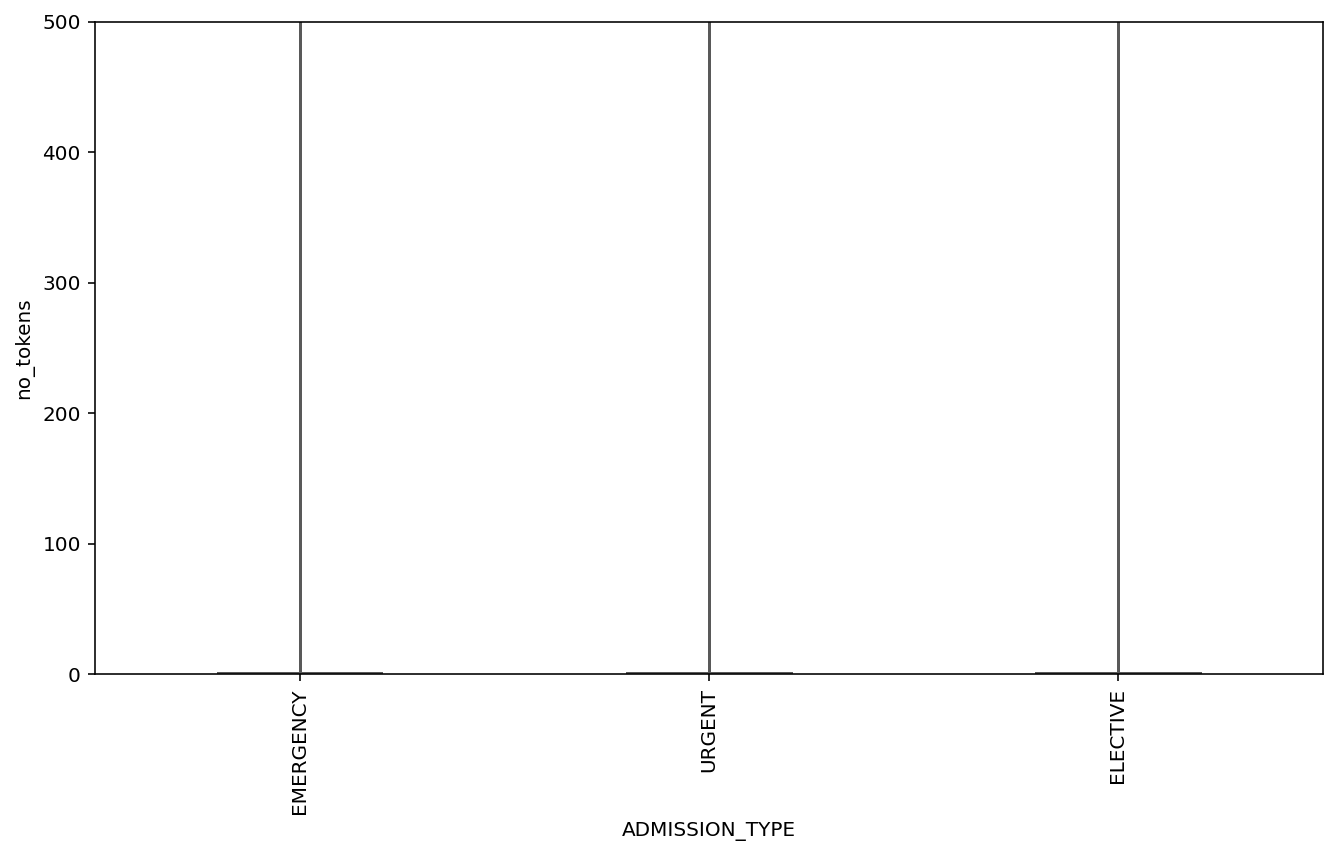

In [ ]:
#cut-off diagram at y=500
multi_boxplot(df_train, 'ADMISSION_TYPE', 'no_tokens', ylim=500)

### Build a simple vectorizer (with Bag of Words features)

Now that we have a way to convert free-text into tokens, we need a way to create features from these tokens. 

In [ ]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizer_better)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
X

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [ ]:
# we can visualize this small example if we convert it to an array
X.toarray()

array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [ ]:
# get the column names
vect.get_feature_names()

['about',
 'amazing',
 'data',
 'is',
 'modeling',
 'of',
 'part',
 'predictive',
 'science',
 'the']

## build a vectorizer on the clinical notes

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better)

# this could take a while
vect.fit(df_train.TEXT.values)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer_better at 0x7fef9d4e7170>,
                vocabulary=None)

# Zipf's law

A law about patterns occuring in languages, proprosed by the linguist George Kingsley Zipf. Given some corpus of natural language, the frequency of a word is inversely proportional to its rank in the frequency table. The most frequent word will appear with a frequency of f. The next most (second most) frequent word will have a frequency of f/2. The third most frequent word will appear f/3 times. 

In [ ]:
import pandas as pd

NameError: ignored

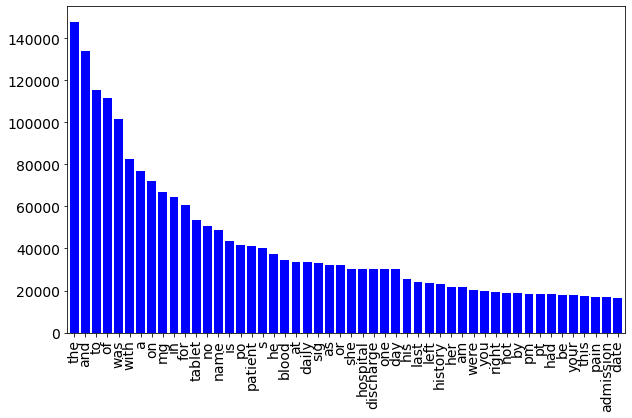

In [ ]:
import numpy as np

neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out tokens dataframe by pickling it into tokens.pickle
pickle_out = open(path + "term_freq_df.pickle", "wb")
pickle.dump(term_freq_df, pickle_out)
pickle_out.close()



In [ ]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizer_better, 
                       stop_words = my_stop_words)
# this could take a while
vect.fit(df_train.TEXT.values)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer_better at 0x7fef9d4e7170>,
                vocabulary=None)

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes dataframe by pickling it into df_adm_notes.pickle
pickle_out = open(path + "vect.pickle", "wb")
pickle.dump(vect, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load vect into our current script
pickle_in = open(path + "vect.pickle", "rb")
vect = pickle.load(pickle_in)

In [ ]:
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_train.selftext_nouns)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes dataframe by pickling it into df_adm_notes.pickle
pickle_out = open(path + "cv_matrix.pickle", "wb")
pickle.dump(cv_matrix, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load cv_matrix into our current script
pickle_in = open(path + "cv_matrix.pickle", "rb")
cv_matrix = pickle.load(pickle_in)

In [ ]:
#get all the unique words in the corpus
vocab = cv.get_feature_names()

#show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,00,000,0000,000s,000u,001,002,003,004,0045,005,006,007,008,009,01,011,012,014,015,017,018,02,020,021,023,024,025,027,02pm,02sat,03,033,035,0352,03mcg,03pm,04,045,04pm,...,zogran,zoladex,zoledronic,zollinger,zolmitriptan,zoloft,zolpidem,zombie,zometa,zomig,zonaglomerulosa,zone,zonegran,zones,zonisamide,zoo,zoonotic,zopenex,zopidem,zoster,zostrix,zosyin,zosym,zosyn,zoysn,zpak,zubsequent,zyban,zydi,zydis,zygoma,zygomatic,zygomaticosphenoid,zygomycosis,zyloprim,zymar,zynvox,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4182,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out df_adm_notes dataframe by pickling it into df_adm_notes.pickle
pickle_out = open(path + "vocab.pickle", "wb")
pickle.dump(vocab, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#load vocab into our current script
pickle_in = open(path + "vocab.pickle", "rb")
vocab = pickle.load(pickle_in)

### Bag of N-Grams Model

In [ ]:
#setting the n-gram range to 1,2 to get unigrams and bigrams respectively
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(df_train.selftext_nouns)

bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab)

#### TF-IDF Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_train.selftext_nouns)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

### Document Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(similarity_matrix, 'ward')
pd.DataFrame(Z, columns =['Document\Cluster 1', 'Document\Cluster 2',
                         'Distance', 'Cluster Size'], dtype='object')

In [ ]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

In [ ]:
from scipy.cluster.hierarchy import fcluster
max_dist = 1.0

cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([df_train.selftext_nouns, cluster_labels], axis=1)

Transform notes into the vector format

In [ ]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

Get labels


In [ ]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out X_train_tf dataframe by pickling it into X_train_tf.pickle
pickle_out = open(path + "X_train_tf.pickle", "wb")
pickle.dump(X_train_tf, pickle_out)
pickle_out.close()

#save out X_valid_tf dataframe by pickling it into X_valid_tf.pickle
pickle_out = open(path + "X_valid_tf.pickle", "wb")
pickle.dump(X_valid_tf, pickle_out)
pickle_out.close()

In [ ]:
import pickle
path = "/content/gdrive/My Drive/Colab Notebooks/hospital_data/"

#save out y_train dataframe by pickling it into y_train.pickle
pickle_out = open(path + "y_train.pickle", "wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

#save out y_valid dataframe by pickling it into y_valid.pickle
pickle_out = open(path + "y_valid.pickle", "wb")
pickle.dump(y_valid, pickle_out)
pickle_out.close()

# Step 3: Build a simple predictive model

***Topic Modelling with Gensim***

In [ ]:
import gensim.corpora as corpora

#Create Dictionary
id2word = corpora.Dictionary(tokens)

#Create Corpus
texts = tokens

#Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

#View
print(corpus[:1][0][:30])

TypeError: ignored

Build a simple predictive model that takes the bag-of-words inputs and predicts if a patient will be re-admitted in 30 days (YES = 1, NO = 0)

Use logistic regression from scikit-learn

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)  #C is the coefficient for regularization, a technique used to try to minimize overfitting
clf.fit(X_train_tf, y_train)

Calculate probability of re-admission for each sample with the fitted model

In [ ]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

In [ ]:
print(y_train[:10].values)
print(y_train_preds[:10])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB().fit(X_train_tf, y_train)

In [ ]:
import numpy as np
predicted = nb_clf.predict(X_valid_tf)
np.mean(predicted == y_valid)

In [ ]:
from sklearn.svm import SVC
#svm = SVC(kernel='linear')
#model_svm = svm().fit(X_train_tf, y_train)
model_svm = svm.fit(X_train_tf, y_train)
predicted_svm = model_svm.predict(X_valid_tf)
np.mean(predicted_svm == y_valid)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=3)

#Train the model using the training set
model_KNN = KNN.fit(X_train_tf, y_train)
predicted_KNN = model_KNN.predict(X_valid_tf)
np.mean(predicted_svm == y_valid)

### Gradient Boosting

Gradient Boosting is a class of ensemble learning. 

In [ ]:
#gradient boosting for classification in scikit-learn

from numpy import mean
from numpy import std
#from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

#evaluate the model
model_gradient_boosting = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_gradient_boosting, X_train_tf, y_train, scoring='accuracy',cv=cv, n_jobs =-1,error_score='raise')
print('Accuracy: %.3f (% .3f)' % (mean(n_scores), std(n_scores)))


#### Use the Gradient Boosting Classifier model and see how it performs on validation dataset:

In [ ]:
predicted_GBC = model_GBC.predict(X_valid_tf)
np.mean(predicted_GBC == y_valid)

In [ ]:
#Evaluating the model 
from sklearn import metrics 
accuracy_score = metrics.accuracy_score(predicted_GBC, y_test)

In [ ]:
import scikitplot as skplt
from sklearn.metrics import plot_confusion_matrix
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(y_valid, predicted_GBC,
                            title="Confusion Matrix for Bagging",
                            cmap="Oranges",
                            ax=ax1)

In [ ]:
plt.figure()
plot_learning_curves(X_train_tf, y_train, X_valid_tf, y_valid, model_gradient_boosting, print_model=False, style='ggplot')
plt.show()

### Ensemble Learning - Bagging

In [ ]:
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier

#Create an instance of the DecisionTreeClassifier class and pass it to the BaggingClassifier():
dt_model = DecisionTreeClassifier(criterion='entropy')
bag_dt_model = BaggingClassifier(dt_model, max_features=1.0, n_estimators=5, \
                                random_state=1, bootstrap=True)      
#for the parameter "boostrap=True", this means that the samples will be drawn with replacement

#fit the model on the training data as follows:
bag_dt_model.fit(X_train_tf, y_train)

#to look at the score after passing the validation data to the model:
bag_dt_model.score(X_valid_tf, y_valid)

#use the predict function to predict the response variable (re-admission):
predictedvalues_bag_dt = bag_dt_model.predict(X_valid_tf)


In [ ]:
np.mean(predictedvalues_bag_dt == y_valid)

In [ ]:
import scikitplot as skplt
from sklearn.metrics import plot_confusion_matrix
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(y_valid, predictedvalues_bag_dt,
                            title="Confusion Matrix for Bagging",
                            cmap="Oranges",
                            ax=ax1)

In [ ]:
plt.figure()
plot_learning_curves(X_train_tf, y_train, X_valid_tf, y_valid, bag_dt_model, print_model=False, style='ggplot')
plt.show()

### Ensemble Learning - Stacking

In [ ]:
#for the base learners
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#for the meta learner
from sklearn.linear_model import LogisticRegression

#Create instances of the base learners and fit the model on the training data:
model_1 = MultinomialNB()
model_2 = KNeighborsClassifier(n_neighbors=1)
model_3 = DecisionTreeClassifier()
model_4 = SVC()

#train a list of the models
base_learner_1 = model_1.fit(X_train_tf, y_train)
base_learner_2 = model_2.fit(X_train_tf, y_train)
base_learner_3 = model_3.fit(X_train_tf, y_train)
base_learner_4 = model_4.fit(X_train_tf, y_train)


In [ ]:
#Use the base learners on the validation subset to make predictions:
val_prediction_base_learner_1 =base_learner_1.predict(X_valid_tf)
val_prediction_base_learner_2 =base_learner_2.predict(X_valid_tf)
val_prediction_base_learner_3 =base_learner_3.predict(X_valid_tf)
val_prediction_base_learner_4 =base_learner_4.predict(X_valid_tf)

In [ ]:
#Create a stacked array with the predictions from the base learners:
import numpy as np
prediction_test_stack = np.dstack([val_prediction_base_learner_1, val_prediction_base_learner_2, val_prediction_base_learner_3, val_prediction_base_learner_4])

#Stack the actual outcomes ie. Y_test with prediction_stack
final_train_stack = np.dstack([prediction_test_stack, y_valid])

#convert the final_train_stack stacked array to a DataFrame and add column names to each of the columns. Then verify
#the dimensions and look at a few rows from the start of the dataframe
stacked_train_dataframe = pd.DataFrame(final_train_stack[0, 0:5400], columns = 'MNB_VAL KNN_VAL DT_VAL SVC_VAL Y_VAL'.split())

print(stacked_train_dataframe.shape)
print(stacked_train_dataframe.head(5))

In [ ]:
#Train the meta-learner using the stacked array that we created previously

meta_learner= LogisticRegression()
meta_learner_model = meta_learner.fit(stacked_train_dataframe.iloc[:,0:4], stacked_train_dataframe['Y_VAL'])


In [ ]:
#Create the stacked test set with the testing subset:
#Take the test data (new data)
#Apply the base learners on this newe data to make predictions

#Use the models to make predictions on the validation create a new stacked dataset
test_prediction_base_learner_1 = base_learner_1.predict(X_valid_tf)
test_prediction_base_learner_2 = base_learner_2.predict(X_valid_tf)
test_prediction_base_learner_3 = base_learner_3.predict(X_valid_tf)
test_prediction_base_learner_4 = base_learner_4.predict(X_valid_tf)

#Create the stacked data
final_test_stack = np.dstack([test_prediction_base_learner_1, test_prediction_base_learner_2, test_prediction_base_learner_3, test_prediction_base_learner_4 ])

In [ ]:
#Convert the final_test_stack stacked array to a DataFrame and add column names to each of the columns
#Verify the dimensions and look at first few rows:

stacked_test_dataframe = pd.DataFrame(final_test_stack[0, 0:3000], columns = 'MNB_TEST KNN_TEST DT_TEST SVC_TEST'.split())
print(stacked_test_dataframe.shape)
print(stacked_test_dataframe.head(5))

The stacked array now has 109 observations and 4 columns in the stacked_test_dataframe.


In [ ]:
#Check the accuracy of the base_learner on X validation dataset:
test_prediction_base_learner_1 = base_learner_1.predict(X_valid_tf)
test_prediction_base_learner_2 = base_learner_2.predict(X_valid_tf)
test_prediction_base_learner_3 = base_learner_3.predict(X_valid_tf)
test_prediction_base_learner_4 = base_learner_4.predict(X_valid_tf)

from sklearn.metrics import accuracy_score
print("Accuracy from Multinomial Naive Bayes: ", accuracy_score(y_valid, test_prediction_base_learner_1))
print("Accuracy from KNeighborsClassifier: ", accuracy_score(y_valid, test_prediction_base_learner_2))
print("Accuracy from DecisionTreeClassifier: ", accuracy_score(y_valid, test_prediction_base_learner_3))
print("Accuracy from SVC: ", accuracy_score(y_valid, test_prediction_base_learner_4))


In [ ]:
#Use the meta-learner on the stacked validation data and check the accuracy:
test_predictions_meta_learner = meta_learner_model.predict(stacked_test_dataframe)
print("Accuracy from Meta Learner:", accuracy_score(y_valid, test_predictions_meta_learner))

The accuracy from the Meta Leaner applied on the validation dataset is 0.9174, which is higher than the accuracy scores from the individual base learners. 

### Learning curve for Stacking

Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html


In [ ]:
#for the base learners
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves

#for the meta learner
from sklearn.linear_model import LogisticRegression

#Create instances of the base learners and fit the model on the training data:
model_1 = MultinomialNB()
model_2 = KNeighborsClassifier(n_neighbors=1)
model_3 = DecisionTreeClassifier()
model_4 = SVC()
meta_learner= LogisticRegression()

stacking_classifier = StackingClassifier(classifiers=[model_1, model_2, model_3, model_4], meta_classifier=meta_learner)

In [ ]:
#plot learning curves
    
plt.figure()
plot_learning_curves(X_train_tf, y_train, X_valid_tf, y_valid, stacking_classifier, print_model=False, style='ggplot')
plt.show()

# Step 4. Calculate Performance Metrics

<img src="perf_metrics.png">

In [ ]:
def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)


The threshold value used for predicting positive is 0.5.

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

The ROC curve is a plot that shows the trade-off between true positive rate and false positive rate as you change the threshold value used to define what is predicted as positive and what is predicted as negative.

The ROC curve plots True Positive Rate (TPR) vs False Positive Rate (FPR) at different classification thresholds. When you decrease the threshold value for classification, the model will predict a greater number of items as positive, which will also increase the False positives, and True Positives. 

AUC value is the Area Under the ROC Curve, which represents the area under the ROC curve from (0,0) to (1,1). It is a performance measurement for classification problems, and represents how well a model can distinguish between classes. The higher the AUC value, the better a model is at predicting class 0 as 0, and class 1 as class 1. 

# Step 5. Try to improve the model

At this point, you might be tempted to calculate the performance on your test set and see how you did. But wait! We made many choices  (a few below) which we could change and see if there is an effect:
- which and how much data to use - should we spend time getting more data?
- how to tokenize - should we use something called stemming too? 
- how to vectorizer - should we change the number of words?
- how to regularized the logistic regression - should we change C or penalty?
- which model to use?

When we want to improve the model, we want to do it in a data-driven manner (if we can). 

You can spend a lot of time on 'hunches', that don't end up panning out. 

There are a few techniques that will help us get big insight.  

I read a lot of articles about data science and luckily most people post their code.

### Tip A: Use other people's code for nice visualizations. Source: https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e

Visualize the top words for positive and negative classes to see if there are any patterns which could give insight into additional features to add or remove

In [ ]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
importance = get_most_important_features(vect, clf, 50)
    
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

In [ ]:
my_new_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x']

In [ ]:
vect = CountVectorizer(lowercase = True, max_features = 3000, tokenizer = tokenizer_better,stop_words =my_new_stop_words)
#
# This could take a while
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

### Tip B: pick a single metric for evaluation

all decisions will have a trade-off on the metrics described above. Let's choose AUC for this project as it balances FPR and TPR. 

### Tip C: plot a learning curve

Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
title = "Learning Curves (Logistic Regression)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = LogisticRegression( C = 0.0001, penalty = 'l2')
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

From the learning curve, some overfitting can be observed, but adding more data is likely not going to drastically change the AUC on a validation set. 

### Tip D: get an understanding of how the hyperparameters affect your results

You can run a grid-search if you want to select the best option out of all your parameters, but for this workshop we will just visually look at them. 

In [ ]:
from sklearn.linear_model import LogisticRegression

Cs = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))

for ii in range(len(Cs)):
    C = Cs[ii]
    print('\n C:', C)
    
    # logistic regression
    
    clf=LogisticRegression(C = C, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

In [ ]:
plt.plot(Cs, train_aucs,'bo-', label ='Train')
plt.plot(Cs, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Logistic Regression - C')
plt.ylabel('AUC')
plt.show()

From the graph, it shows that increasing the C value causes the model to overfit pretty quickly. 

In [ ]:
num_features = [100,300,1000,3000,10000,30000]
train_aucs = np.zeros(len(num_features))
valid_aucs = np.zeros(len(num_features))

for ii in range(len(num_features)):
    num = num_features[ii]
    print('\nnumber of features:', num)
    vect = CountVectorizer(lowercase = True, max_features = num, 
                           tokenizer = tokenizer_better,stop_words =my_new_stop_words)

    # This could take a while
    vect.fit(df_train.TEXT.values)

    X_train_tf = vect.transform(df_train.TEXT.values)
    X_valid_tf = vect.transform(df_valid.TEXT.values)
    y_train = df_train.OUTPUT_LABEL
    y_valid = df_valid.OUTPUT_LABEL
    
    clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC: %.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid

In [ ]:
plt.plot(num_features, train_aucs,'bo-', label ='Train')
plt.plot(num_features, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.show()

Increasing the max_features also causes the model to overfit.

# Final model without death

In [ ]:
# shuffle the samples

rows_not_death = df_adm_notes_clean.DEATHTIME.isnull()

df_adm_notes_not_death = df_adm_notes_clean.loc[rows_not_death].copy()
df_adm_notes_not_death = df_adm_notes_not_death.sample(n = len(df_adm_notes_not_death), random_state = 42)
df_adm_notes_not_death = df_adm_notes_not_death.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_not_death.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_not_death.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_not_death) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)


In [ ]:
my_new_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x']

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(lowercase = True, max_features = 3000, 
                       tokenizer = tokenizer_better,
                      stop_words = my_new_stop_words)

# This could take a while
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]
y_test_preds = model.predict_proba(X_test_tf)[:,1]

In [ ]:
from sklearn.metrics import average_precision_score
average_precision_clf = average_precision_score(y_test, y_test_preds)

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, X_test_tf, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision_clf))

In [ ]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f'%(len(y_train),sum(y_train)/ len(y_train)))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid),sum(y_valid)/ len(y_valid)))
print('Test prevalence(n = %d): %.3f'%(len(y_test),sum(y_test)/ len(y_test)))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
import pickle